In [1]:
import numpy as np
import pandas as pd
import csv
import keras.backend as K
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [58]:
# train_len = 25253
# validation_len = 9471
# test_len = 13794
train_length = 2684
val_length = 726
test_length = 1498

def load_features(filename,
                  skip_header=True,
                  skip_instname=True,
                  delim=' ',
                  num_lines=0):
    if num_lines == 0:
        num_lines = get_num_lines(filename, skip_header)

    data = np.empty(
        (num_lines, 50), float)

    with open(filename, 'r') as csv_file:
        if skip_header:
            next(csv_file)
        c = 0
        for line in tqdm(csv_file):
            offset = 0
            if skip_instname:
                offset = line.find(delim) + 1
            data[c, :] = np.fromstring(line[offset:], dtype=float, sep=delim)
            c += 1

    return data

def load_batch_features(filename, start_index=0, amount=0):
    delim = ' '
    
    data = np.empty((amount, 25), float)
    
    with open(filename, 'r') as csv_file:
        for i, line in tqdm(enumerate(csv_file)):
            if i < start_index:
                continue
            if i >= start_index + amount:
                break
            index = i - start_index
            data[index, :] = np.fromstring(line, dtype=float, sep=delim)
    return data
    
def load_batch_labels(filename, start_index=1, amount=0):
    labels = np.empty((amount, 3), float)
    delim = ','
    
    with open(filename, 'r') as csv_file:
        for i, line in tqdm(enumerate(csv_file)):
            if i < start_index:
                continue
            if i >= start_index + amount:
                break
            cols = np.fromstring(line, dtype=float, sep=delim)
            index = i - start_index
            labels[index, :] = cols[1:]
    return labels
    
def get_num_lines(filename, skip_header):
    with open(filename, 'r') as csv_file:
        if skip_header:
            next(csv_file)
        c = 0
        for line in csv_file:
            c += 1
    return c

def load_labels(filename,
                  skip_header=True,
                  skip_instname=True,
                  delim=' ',
                  num_lines=0):
    if num_lines == 0:
        num_lines = get_num_lines(filename, skip_header)

    data = np.empty(
        (num_lines, 3), float)

    with open(filename, 'r') as csv_file:
        if skip_header:
            next(csv_file)
        c = 0
        for line in tqdm(csv_file):
            offset = 0
            if skip_instname:
                offset = line.find(delim) + 1
            data[c, :] = np.fromstring(line[offset:], dtype=float, sep=delim)
            c += 1

    return data
    
    
def get_scaler(x):
    x_scaler = StandardScaler()
    x_scaler.fit(x)
  
    return x_scaler

def scale_data(scaler, data):
    if data.ndim > 2:
        data = data.reshape(-1, data.shape[2])
    scaled = scaler.transform(data)
    
    return scaled

def ccc(gold, pred):
    gold       = K.squeeze(gold, axis=-1)
    pred       = K.squeeze(pred, axis=-1)
    gold_mean  = K.mean(gold, axis=-1, keepdims=True)
    pred_mean  = K.mean(pred, axis=-1, keepdims=True)
    covariance = (gold-gold_mean)*(pred-pred_mean)
    gold_var   = K.mean(K.square(gold-gold_mean), axis=-1,  keepdims=True)
    pred_var   = K.mean(K.square(pred-pred_mean), axis=-1, keepdims=True)
    ccc        = K.constant(2.) * covariance / (gold_var + pred_var + K.square(gold_mean - pred_mean) + K.epsilon())
    return ccc

def ccc_loss(gold, pred):
    ccc_loss = K.constant(1.) - ccc(gold, pred)
    return ccc_loss


### Batch loading to train LSTM-RNN

- First, load all data to get scalers that covers for each partition data
- Batching the data to train
- Batching the data to validation

In [88]:
data_path = './Functional_features/'

seq_len = 388
n_features = 25


# load all data to get a scaler that covers all data
print("Loading training samples...")
x_train = load_features(data_path+'train.txt', skip_header=False, skip_instname=False)
train_labels = load_labels(data_path+'train_labels.txt', skip_header=False, skip_instname=False)
y_train = train_labels.reshape((train_length, seq_len, 3))

print("Loading finished, Scaling...")
x_scaler = get_scaler(x_train)

# Scaling acoustic features
x_train_scaled = scale_data(x_scaler, x_train)
# Scaling labels from [-100,100] to [-1, 1]
f = lambda x: x * 0.01
y_train_scaled = f(y_train)
x_train_scaled = x_train_scaled.reshape((train_length, seq_len, n_features * 2))
print('x_train shape:', x_train_scaled.shape)
print('y_train shape:', y_train_scaled.shape)
print("End of loading and preprocessing training samples")

print("Loading validation samples...")
x_validation = load_features(data_path+'validation.txt', skip_header = False, skip_instname=False)
val_labels = load_labels(data_path+'validation_labels.txt', skip_header=False, skip_instname=False)
y_validation = val_labels.reshape((val_length, seq_len, 3))
print("Loading finished, Scaling...")
x_val_scaled = scale_data(x_scaler, x_validation)
y_val_scaled = f(y_validation)
x_val_scaled = x_val_scaled.reshape((val_length, seq_len, n_features * 2))

print('x_validation shape:', x_val_scaled.shape)
print('y_validation shape:', y_val_scaled.shape)
print("End of loading and preprocessing validation samples")

print("Loading testing samples...")
x_test = load_features(data_path+'test.txt', skip_header = False, skip_instname=False)
test_labels = load_labels(data_path+'test_labels.txt', skip_header=False, skip_instname=False)
y_test = test_labels.reshape((test_length, seq_len, 3))
print("Loading finished, Scaling...")
x_test_scaled = scale_data(x_scaler, x_test)
y_test_scaled = f(y_test)
x_test_scaled = x_test_scaled.reshape((test_length, seq_len, n_features * 2))

print('x_test shape:', x_test_scaled.shape)
print('y_test shape:', y_test_scaled.shape)
print("End of loading and preprocessing test samples")

Loading training samples...


1041392it [00:10, 96386.43it/s]
1041392it [00:02, 395019.57it/s]


Loading finished, Scaling...
x_train shape: (2684, 388, 50)
y_train shape: (2684, 388, 3)
End of loading and preprocessing training samples
Loading validation samples...


281688it [00:02, 97375.12it/s] 
281688it [00:00, 387605.75it/s]


Loading finished, Scaling...
x_validation shape: (726, 388, 50)
y_validation shape: (726, 388, 3)
End of loading and preprocessing validation samples
Loading testing samples...


581224it [00:05, 97845.87it/s] 
581224it [00:01, 391790.30it/s]


Loading finished, Scaling...
x_test shape: (1498, 388, 50)
y_test shape: (1498, 388, 3)
End of loading and preprocessing test samples


In [31]:
# headers = y_train.columns
# print(headers)
headers = ['Arousal', 'Valence', 'Dominance']

In [32]:
len(y_train_scaled)

2684

### Building RNN-LSTM model


In [14]:
import keras.backend as K
from keras.models import Model, save_model, load_model, Sequential
from keras.layers import Input, Dense, Masking, LSTM, Dropout, TimeDistributed, Bidirectional, Flatten, Embedding, Conv1D, BatchNormalization, MaxPool1D
from tensorflow.keras.optimizers import RMSprop, Adam

from numpy.random import seed
from tensorflow.keras.utils import set_random_seed
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

### Multi-task learning

three models are integrated and each model covers Arousal, Valence, Dominance respectively.

In [83]:
# train_length = 25253
# val_length = 9471
# test_length = 13794
# train_length = 41815
# val_length = 13451
# test_length = 22633

n_features = 50
random_seed = 42

epochs = 50
batch_size = 32


def create_model(n_units1=64, n_units2=32):
    model = Sequential()
    inputs = Input(shape=(seq_len, n_features), dtype=float)
    mask = Masking()(inputs)
    lstm_1 = LSTM(n_units1, return_sequences=True)(mask)
    lstm_2 = LSTM(n_units2, return_sequences=True)(lstm_1)
    modes = lstm_2
    output = [TimeDistributed(Dense(1), name=name)(modes) for i, name in enumerate(headers)]
    
    model = Model(inputs=inputs, outputs=output)
    
    rmsprop = RMSprop(lr=0.0001)
    model.compile(optimizer=rmsprop, loss=ccc_loss, metrics=[ccc])
    return model
#
# def create_arousal(n_units1=64, n_units2=32, dropout, bidirection=False):
#     a_input = Input(shape=(time_step, n_features), dtype=float, name='arousal_model_input')
#     mask = Masking()(a_input)
#     if bidirection:
#         a_lstm1 = Bidirectional(LSTM(n_units1, return_sequences=True))(mask)
#     else:
#         a_lstm1 = LSTM(n_units1, return_sequences=True)(mask)
#     a_lstm1 = Dropout(dropout)(a_lstm1)
#     if bidirection:
#         a_lstm2 = Bidirectional(LSTM(n_units2, return_sequences=False)(a_lstm1))
#     else:
#         a_lstm2 = LSTM(n_units2, return_sequences=False)(a_lstm1)
#     a_lstm2 = Dropout(dropout)(a_lstm2)
#     a_dense = Dense(
    
    
    

In [84]:
model = create_model(n_units1=64, n_units2=32)
print(model.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 388, 50)]    0           []                               
                                                                                                  
 masking_11 (Masking)           (None, 388, 50)      0           ['input_12[0][0]']               
                                                                                                  
 lstm_21 (LSTM)                 (None, 388, 64)      29440       ['masking_11[0][0]']             
                                                                                                  
 lstm_22 (LSTM)                 (None, 388, 32)      12416       ['lstm_21[0][0]']                
                                                                                            

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
y_train_scaled.loc[:,['Arousal', 'Dominance']]

,Arousal,Dominance
0,0.131463,0.130148
1,0.120476,0.131123
2,0.112240,0.131850
3,0.107064,0.124378
4,0.099479,0.121350
...,...,...
41810,0.220442,0.146308
41811,0.224396,0.147028
41812,0.229963,0.150131
41813,0.236319,0.156082


In [85]:
y_train_dta = []
y_val_dta = []

index = [0,1,2]
for i in index:
    dim = np.empty((train_length, seq_len, 1))
    dim[:,:,0] = y_train_scaled[:,:,i]
    y_train_dta.append(dim)
    val_dim = np.empty((val_length, seq_len, 1))
    val_dim[:,:,0] = y_val_scaled[:,:,i]
    y_val_dta.append(val_dim)
y_train_dta[2].shape

(2684, 388, 1)

In [86]:
callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = model.fit(x_train_scaled, y_train_dta, 
                    epochs=epochs, 
                    batch_size=batch_size,                     
                    validation_data=(x_val_scaled, y_val_dta), 
                    callbacks=[callback])
# plot_learningCurve(history, epochs)

Epoch 1/50
84/84 [==============================] - 15s 75ms/step - loss: 2.2320 - Arousal_loss: 0.3740 - Valence_loss: 1.0250 - Dominance_loss: 0.8329 - Arousal_ccc: 0.6260 - Valence_ccc: -0.0250 - Dominance_ccc: 0.1671 - val_loss: 1.8593 - val_Arousal_loss: 0.3626 - val_Valence_loss: 1.0190 - val_Dominance_loss: 0.4777 - val_Arousal_ccc: 0.6374 - val_Valence_ccc: -0.0190 - val_Dominance_ccc: 0.5223
Epoch 2/50
84/84 [==============================] - 4s 42ms/step - loss: 1.5331 - Arousal_loss: 0.2910 - Valence_loss: 1.0048 - Dominance_loss: 0.2373 - Arousal_ccc: 0.7090 - Valence_ccc: -0.0048 - Dominance_ccc: 0.7627 - val_loss: 1.5948 - val_Arousal_loss: 0.2913 - val_Valence_loss: 0.9954 - val_Dominance_loss: 0.3081 - val_Arousal_ccc: 0.7087 - val_Valence_ccc: 0.0046 - val_Dominance_ccc: 0.6919
Epoch 3/50
84/84 [==============================] - 4s 43ms/step - loss: 1.2954 - Arousal_loss: 0.2562 - Valence_loss: 0.8545 - Dominance_loss: 0.1846 - Arousal_ccc: 0.7438 - Valence_ccc: 0.1455

In [74]:
y_pred=model.predict(x_val_scaled)
y_pred

296/296 [==============================] - 4s 11ms/step


array([[0.48639995],
       [0.31548062],
       [0.49207112],
       ...,
       [0.29789454],
       [0.26807895],
       [0.19476964]], dtype=float32)

In [55]:
y_val_scaled

,Arousal,Valence,Dominance
0,0.163089,0.159229,0.207163
1,0.405032,0.354663,0.399944
2,0.410818,0.334092,0.365697
3,0.322820,0.287947,0.366822
4,0.304500,0.274624,0.374503
...,...,...,...
9466,0.383390,-0.080103,0.238497
9467,0.379031,-0.065992,0.242540
9468,0.382344,-0.043107,0.245435
9469,0.385036,-0.021573,0.256853


(array([  76.,  520.,  611.,  810., 1098., 1894., 2467., 1392.,  466.,
         137.]),
 array([-0.06760712,  0.00668762,  0.08098235,  0.15527709,  0.22957182,
         0.30386657,  0.37816128,  0.45245603,  0.52675074,  0.6010455 ,
         0.67534024], dtype=float32),
 <BarContainer object of 10 artists>)

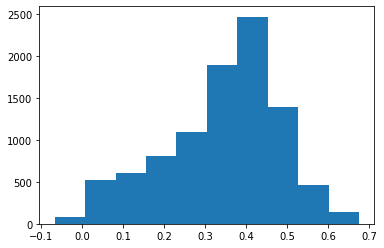

In [75]:
plt.hist(y_pred)

(array([  52.,  105.,  399., 1544., 2293., 2908., 1481.,  490.,  138.,
          61.]),
 array([-0.13312835, -0.05516669,  0.02279497,  0.10075663,  0.17871829,
         0.25667994,  0.3346416 ,  0.41260326,  0.49056492,  0.56852658,
         0.64648824]),
 <BarContainer object of 10 artists>)

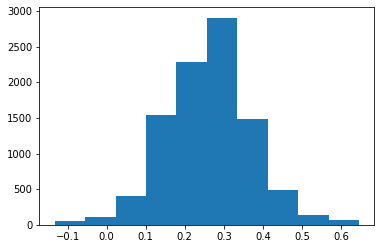

In [76]:
plt.hist(y_val_scaled['Dominance'])

### Linguistic model

In [17]:
y_train

,Unnamed: 0,Filename,Time,Arousal,Valence,Dominance
0,0,MSP-PODCAST_0021_0003,0.0-2.0,13.146256,16.753491,13.014761
1,1,MSP-PODCAST_0021_0003,0.0-2.5,12.047585,16.634094,13.112332
2,2,MSP-PODCAST_0021_0003,0.0-3.0,11.223967,16.184754,13.185027
3,3,MSP-PODCAST_0021_0003,0.0-3.5,10.706417,15.996252,12.437792
4,4,MSP-PODCAST_0021_0003,0.0-4.0,9.947854,15.493055,12.135020
...,...,...,...,...,...,...
41810,41810,MSP-PODCAST_1353_0041,22.0-26.0,22.044157,16.009710,14.630833
41811,41811,MSP-PODCAST_1353_0041,22.5-26.15,22.439580,16.266371,14.702753
41812,41812,MSP-PODCAST_1353_0041,23.0-26.15,22.996343,16.350448,15.013053
41813,41813,MSP-PODCAST_1353_0041,23.5-26.15,23.631934,16.277397,15.608230
